In [68]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [69]:
import pandas as pd

df = pd.read_csv('/content/drive/My Drive/Online Retail.csv')
print(df.columns)
print('done read dataset')

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')
done read dataset


In [70]:
products = df[['StockCode','Description']].copy()
products.head()
products = products.groupby(products['StockCode']).filter(lambda x : x.notnull().values.all())
print('done creating product dictionary')

done creating product dictionary


In [71]:
import datetime as dt

NOW = dt.datetime(2011,12,10)
users = df[['InvoiceNo','CustomerID','InvoiceDate','Quantity','UnitPrice','StockCode']][df['Quantity']>0][df['UnitPrice'] > 0].copy()
users['total_buyed'] = users['Quantity'] * users['UnitPrice']
#users['total_buyed'].plot()
users['InvoiceDate'] = pd.to_datetime(users['InvoiceDate'])
usersRfm = users.groupby('CustomerID').agg({'InvoiceDate': lambda x: (NOW - x.max()).days, 'InvoiceNo': lambda x: len(x), 'total_buyed': lambda x: x.sum()}).rename({'InvoiceNo':'times_buy', 'InvoiceDate':'last_buy'}, axis='columns')
users=usersRfm
users=users.reset_index()
usersRfm = usersRfm.reset_index()[['last_buy','times_buy','total_buyed']]
print(usersRfm.head())
print('createRfm')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


   last_buy  times_buy  total_buyed
0       325          1     77183.60
1         2        182      4310.00
2        75         31      1797.24
3        18         73      1757.55
4       310         17       334.40
createRfm


[0.9844418340416883, 0.9610532770588399, 0.9541412626775648, 0.8362752944524187, 0.773446606692752, 0.7300943867948729, 0.7304603232592314, 0.669467990503748, 0.6812440680944135]
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)
done training kmeans


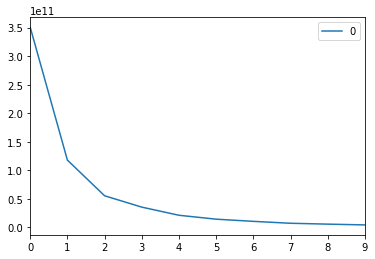

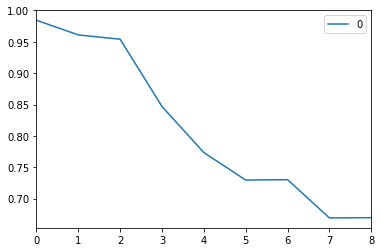

In [72]:
from sklearn.cluster import KMeans

def calculate_WSS(points, kmax):
  sse = []
  for k in range(1, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(points)
    centroids = kmeans.cluster_centers_
    pred_clusters = kmeans.predict(points)
    curr_sse = 0
    # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
    for i in range(len(points)):

      curr_center = centroids[pred_clusters[i]]
      curr_sse += (points.iloc[i, 0] - curr_center[0]) ** 2 + (points.iloc[i, 1] - curr_center[1]) ** 2 + (points.iloc[i, 2] - curr_center[2]) ** 2
      
    sse.append(curr_sse)
  return sse

from sklearn.metrics import silhouette_score

def calculate_siluete(x, kmax):
  sil = []

  for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(x)
    labels = kmeans.labels_
    sil.append(silhouette_score(x, labels, metric = 'euclidean'))
  return sil

def train_kmeans(points, k):
  kmeans = KMeans(n_clusters = k).fit(points)
  return kmeans
pd.DataFrame(calculate_WSS(usersRfm,10)).plot()
print(calculate_siluete(usersRfm,10))
pd.DataFrame(calculate_siluete(usersRfm,10)).plot()

kmeans = train_kmeans(usersRfm,4)
print(kmeans)
print('done training kmeans')

In [73]:
#users=users.reset_index()
kmeans.predict(users[['last_buy','times_buy','total_buyed']])
print(users.head())
users['cluster'] = kmeans.predict(users[['last_buy','times_buy','total_buyed']])
print(users.head())
print(users['cluster'].value_counts())
print(users[users['cluster'] == 0].describe())
print(users[users['cluster'] == 1].describe())
print(users[users['cluster'] == 2].describe())
print(users[users['cluster'] == 3].describe())
#print(users[users['cluster'] == 5].describe())
print('done clustering existing users!')

   CustomerID  last_buy  times_buy  total_buyed
0     12346.0       325          1     77183.60
1     12347.0         2        182      4310.00
2     12348.0        75         31      1797.24
3     12349.0        18         73      1757.55
4     12350.0       310         17       334.40
   CustomerID  last_buy  times_buy  total_buyed  cluster
0     12346.0       325          1     77183.60        1
1     12347.0         2        182      4310.00        0
2     12348.0        75         31      1797.24        0
3     12349.0        18         73      1757.55        0
4     12350.0       310         17       334.40        0
0    4300
1      31
3       5
2       2
Name: cluster, dtype: int64
         CustomerID     last_buy    times_buy   total_buyed  cluster
count   4300.000000  4300.000000  4300.000000   4300.000000   4300.0
mean   15301.314884    92.646512    82.897674   1438.190382      0.0
std     1721.694713   100.056203   127.773733   2227.422111      0.0
min    12347.000000     0.

   last_buy  times_buy  total_buyed  CustomerID  clusterSub
1         2        182      4310.00     12347.0           1
2        75         31      1797.24     12348.0           2
3        18         73      1757.55     12349.0           2
4       310         17       334.40     12350.0           0
5        36         85      2506.04     12352.0           2
0    2170
2    1603
1     527
Name: clusterSub, dtype: int64
          last_buy    times_buy  total_buyed    CustomerID  clusterSub
count  2170.000000  2170.000000  2170.000000   2170.000000      2170.0
mean    135.599078    21.412442   373.982347  15318.764516         0.0
std     111.120018    14.341933   231.735350   1720.437926         0.0
min       0.000000     1.000000     3.750000  12350.000000         0.0
25%      38.000000    10.000000   181.022500  13826.500000         0.0
50%      95.000000    19.000000   325.425000  15318.500000         0.0
75%     232.000000    31.000000   533.210000  16777.000000         0.0
max     373

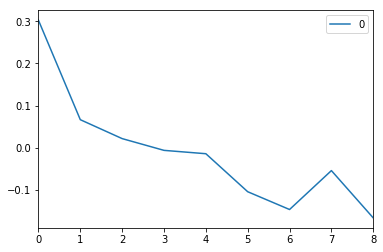

In [74]:
from sklearn.mixture import GaussianMixture

def train_gaus(points, k):
  kmeans = GaussianMixture(n_components=k).fit(points)
  return kmeans


def calculate_siluete_gaus(x, kmax):
  sil = []

  for k in range(2, kmax+1):
    kmeans = GaussianMixture(n_components = k).fit(x)
    labels = kmeans.predict(x)
    sil.append(silhouette_score(x, labels, metric = 'euclidean'))
  return sil

usersSub = users[users['cluster']==0][['last_buy','times_buy','total_buyed','CustomerID']]
pd.DataFrame(calculate_siluete_gaus(usersSub,10)).plot()

kmeansSub = train_gaus(usersSub[['last_buy','times_buy','total_buyed']],3)

usersSub['clusterSub'] = kmeansSub.predict(usersSub[['last_buy','times_buy','total_buyed']])
print(usersSub.head())
print(usersSub['clusterSub'].value_counts())
print(usersSub[usersSub['clusterSub'] == 0].describe())
print(usersSub[usersSub['clusterSub'] == 1].describe())
print(usersSub[usersSub['clusterSub'] == 2].describe())
#print(usersSub[usersSub['clusterSub'] == 3].describe())
print('done clustering existing users!')

users = users.merge(usersSub[['CustomerID','clusterSub']],on='CustomerID',how='left')
print('done training gaus')

In [75]:

print(users.describe())
users[users['cluster'] == 1]

import pickle

pickle.dump(kmeans,open('kmeans.pk','wb'))
pickle.dump(kmeansSub,open('kmeansSub.pk','wb'))

         CustomerID     last_buy  ...      cluster   clusterSub
count   4338.000000  4338.000000  ...  4338.000000  4300.000000
mean   15300.408022    92.059474  ...     0.011526     0.868140
std     1721.808492   100.012264  ...     0.138692     0.927499
min    12346.000000     0.000000  ...     0.000000     0.000000
25%    13813.250000    17.000000  ...     0.000000     0.000000
50%    15299.500000    50.000000  ...     0.000000     0.000000
75%    16778.750000   141.750000  ...     0.000000     2.000000
max    18287.000000   373.000000  ...     3.000000     2.000000

[8 rows x 6 columns]


In [0]:
#users[['last_buy','times_buy','total_buyed']]
users.rename(columns={'last_buy': 'recency', 
                         'times_buy': 'frequency', 
                         'total_buyed': 'monetary_value'}, inplace=True)
userRFMTable = users
pickle.dump(userRFMTable,open('userRfmTable.pk','wb'))
quantiles = userRFMTable.quantile(q=[0.25,0.5,0.75])
quantiles.to_dict()

segmented_rfm = userRFMTable

In [89]:
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1
      
segmented_rfm['r_quartile'] = segmented_rfm['recency'].apply(RScore, args=('recency',quantiles,))
segmented_rfm['f_quartile'] = segmented_rfm['frequency'].apply(FMScore, args=('frequency',quantiles,))
segmented_rfm['m_quartile'] = segmented_rfm['monetary_value'].apply(FMScore, args=('monetary_value',quantiles,))
segmented_rfm.head()

segmented_rfm['RFMScore'] = segmented_rfm.r_quartile.map(str) + segmented_rfm.f_quartile.map(str)  + segmented_rfm.m_quartile.map(str)
segmented_rfm.head()

,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
0,325,1,77183.60,4,4,1,441
1,2,182,4310.00,1,1,1,111
2,75,31,1797.24,3,3,1,331
3,18,73,1757.55,2,2,1,221
4,310,17,334.40,4,4,3,443
